<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early bearing fault detection for WT04



## Table of contents
1. Raw signal
2. Resampled signal
3. Filtered signal with optimal bandpass based on SK
4. Demodulasation using EEMD signals
5. Selecting IMF: Correlation coefficient
6. Envelope spectral analyis
7. Frequency study

In [56]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff, feature_extraction

## 1. Raw signal 

In [58]:
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox','wt04')

File exist


5
110886912


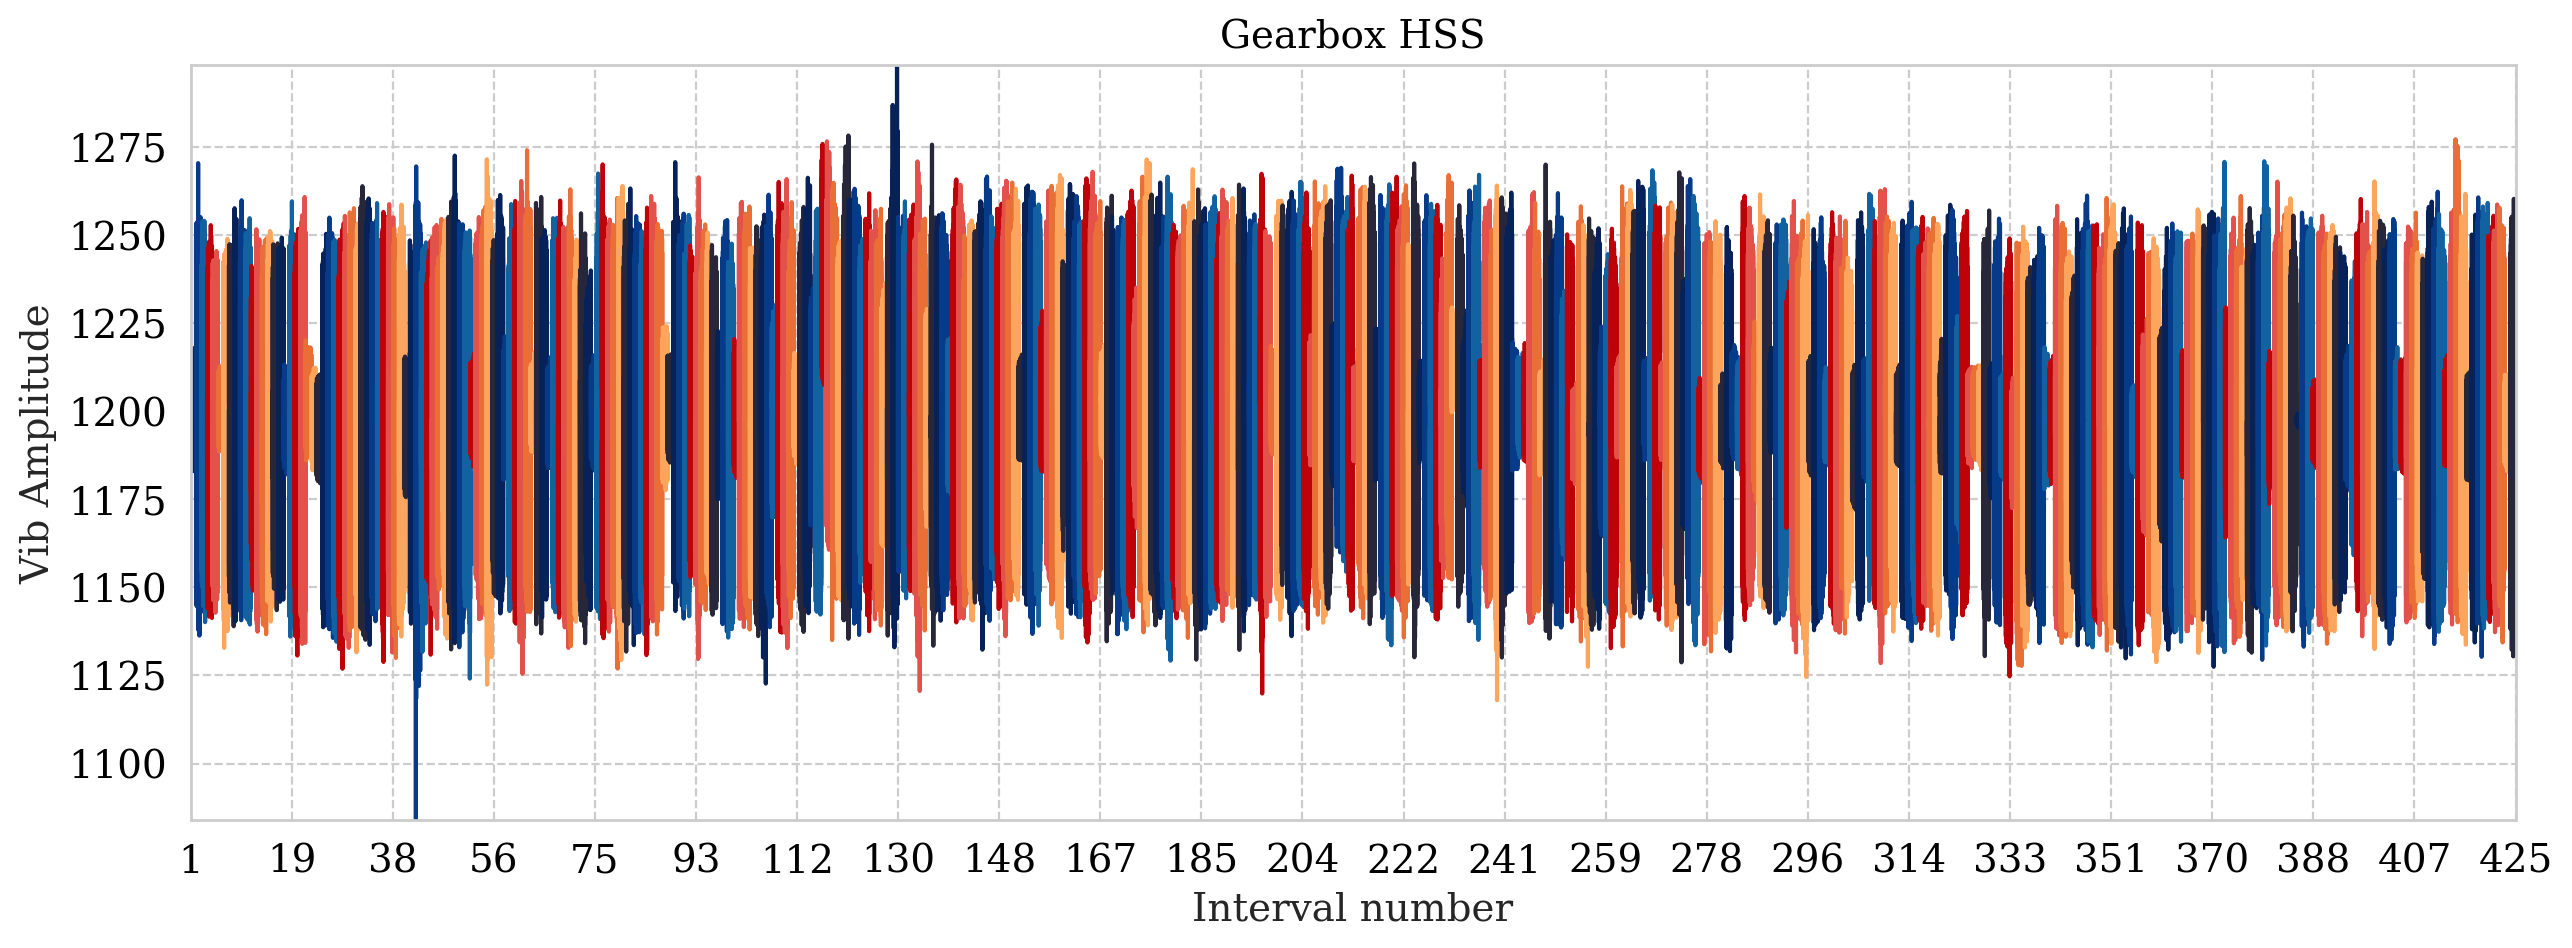

In [59]:
envelope.plot_vib_consecutive(vib_signal)

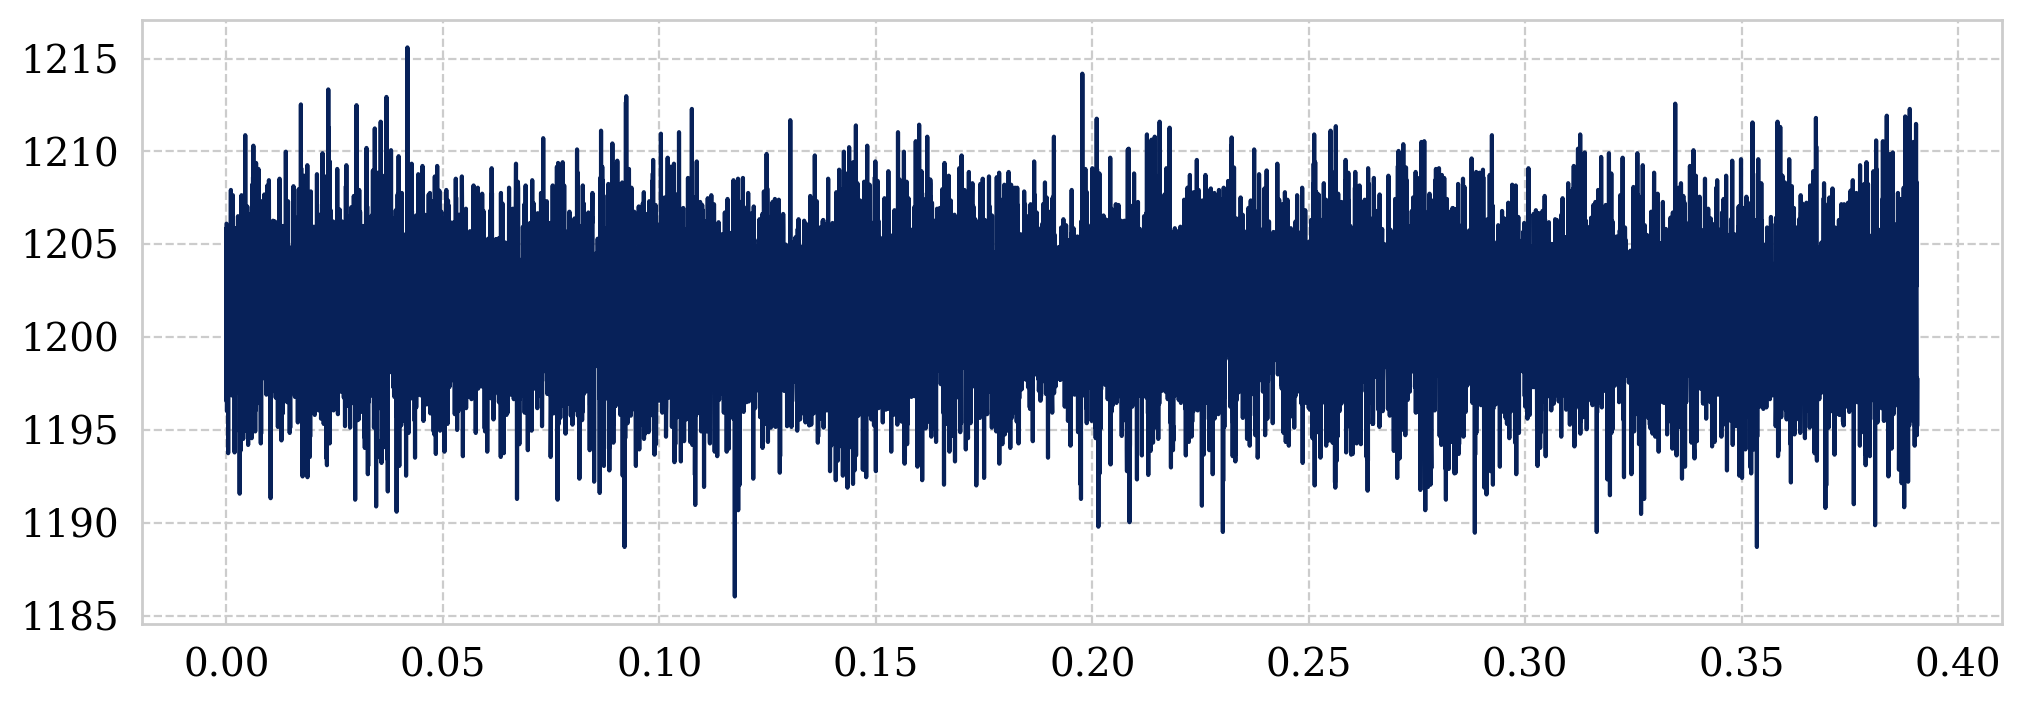

In [60]:
# One interval:
plt.plot(times[0][0:10000],vib_signal[0][0:10000])

In [9]:
# Filtered raw
low_cut = 2000
filtered_raw_vib = []
vib_signal_size = len(vib_signal)

for i, vib_sig in enumerate(vib_signal):
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_raw_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {vib_signal_size} signals', end='\r')
filtered_raw_vib = np.asarray(filtered_raw_vib)

In [61]:
# Reading filtered from disk
filtered_path = '/Volumes/OsvikExtra/signal_data/raw_filtered_2000Hz/gearbox/wt04/filtered/'

num_csvs = len([f for f in os.listdir(filtered_path) 
     if f.endswith('.csv') and os.path.isfile(os.path.join(filtered_path, f)) and f[0]=='f'])

filtered_signals = []
filtered_freqs = []
columns = []
for i in range(num_csvs):
    acc=pd.read_csv(filtered_path+'filtered_raw_'+str(i)+'.csv')
    columns.append('filtered_' + str(i))
    filtered_signals.append(acc.values)
    filtered_freqs.append(acc.shape[0] / times[i][-1])

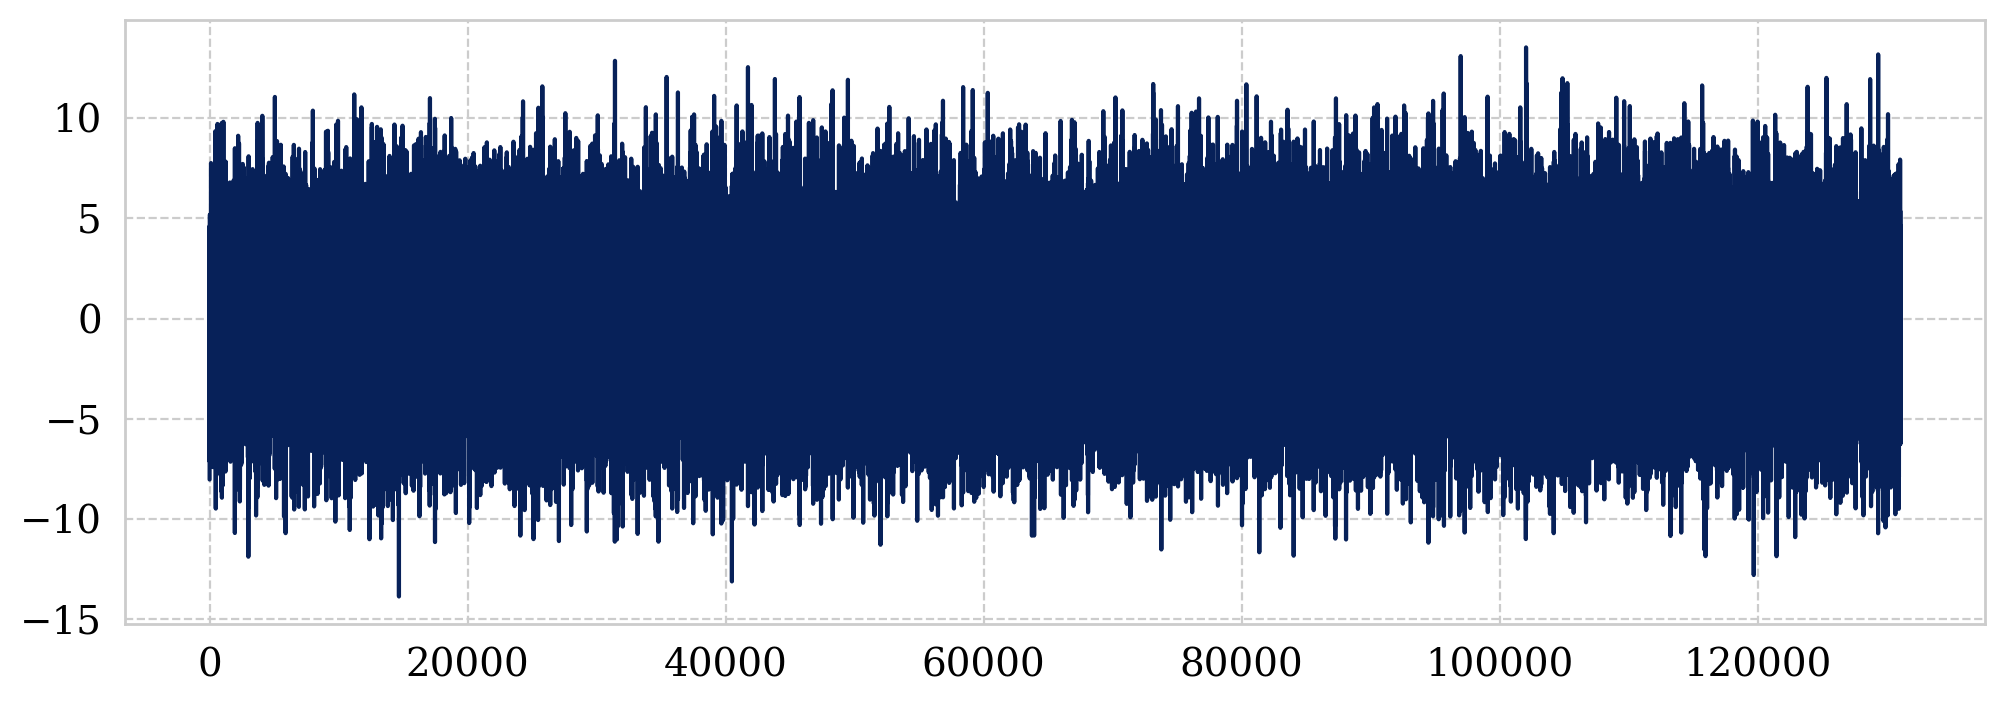

In [9]:
i = 0
plt.plot(filtered_signals[i][0:(len(filtered_signals[0])//2)])
use_signal = filtered_signals[i][0:(len(filtered_signals[0])//2)]

### Optimal bandwidth (filtered raw)

In [62]:
# Finding the optimal bandwidth by taking the mean from the SK
fc_and_bw_path = '/Volumes/OsvikExtra/signal_data/raw_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv'
# Finding the optimal bandwidth by taking the mean from the SK
fc_and_bw_data = pd.read_csv(fc_and_bw_path)
fc_and_bw_data

,File,Frequencies,Bandwidths
0,filtered_raw_0.csv,9600.036621,6400.024414
1,filtered_raw_1.csv,5975.022793,50.000191
2,filtered_raw_10.csv,5625.021458,50.000191
3,filtered_raw_100.csv,9600.036621,6400.024414
4,filtered_raw_101.csv,9600.036621,6400.024414
...,...,...,...
419,filtered_raw_95.csv,3175.012112,50.000191
420,filtered_raw_96.csv,9600.036621,6400.024414
421,filtered_raw_97.csv,9600.036621,6400.024414
422,filtered_raw_98.csv,3025.011540,50.000191


Before filter shape: (424, 9)
After filtering: (322, 9)


,Unnamed: 0,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed,File,Frequencies,Bandwidths
1,1,2697.461426,2332.100098,9.1,256.100006,1456.464986,1,5975.022793,50.000191
2,2,2606.151855,2843.500000,10.0,240.199997,1468.503663,2,8925.034046,50.000191
3,3,2541.849854,2694.100098,10.5,71.099998,1458.875183,3,1775.006771,50.000191
4,4,2853.304199,3293.399902,12.7,269.399994,1460.635409,4,8925.034046,50.000191
6,6,2752.077881,3040.300049,9.7,143.899994,1490.140485,6,3175.012112,50.000191
...,...,...,...,...,...,...,...,...,...
418,418,2579.166504,2568.500000,10.3,266.500000,1469.268894,418,9600.036621,6400.024414
419,419,2565.862793,1585.199951,7.7,358.799988,1420.395518,419,5675.021648,50.000191
420,420,2891.829346,2819.300049,10.4,318.600006,1487.214505,420,9600.036621,6400.024414
421,421,2581.525879,3160.600098,10.2,317.000000,1489.520070,421,3075.011730,50.000191


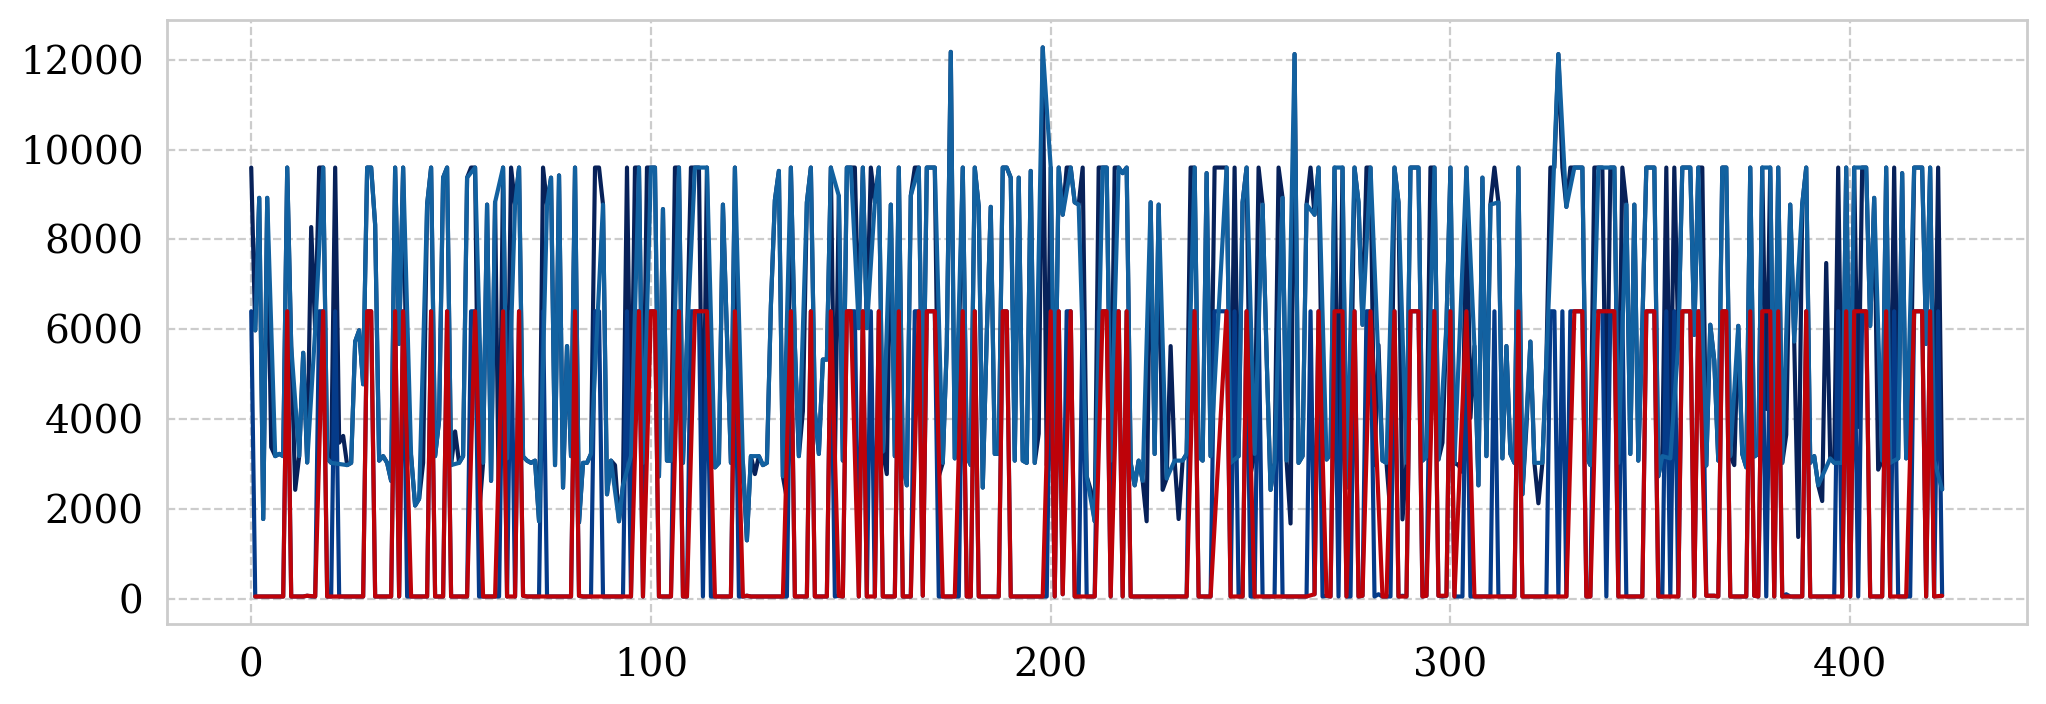

In [63]:
# Make the file column to an int
fc_and_bw_data['File']=fc_and_bw_data['File'].apply(lambda x: int((str(x).split('_'))[2].split('.csv')[0]))
# Sort the df based on this
fc_and_bw_data=fc_and_bw_data.sort_values('File',ascending=True)
fc_and_bw_data = fc_and_bw_data.reset_index(drop=True)

# How the frequencies and bandwidths vary across the intervals for wt4:
fc_and_bw_data['Frequencies'].plot()
fc_and_bw_data['Bandwidths'].plot()

op_data_intervals
concated = pd.concat([op_data_intervals, fc_and_bw_data],axis=1)

print(f"Before filter shape: {concated.shape}")
filter_concated = concated.loc[(concated['AvgSpeed'] >= 1400)]
print(f"After filtering: {filter_concated.shape}")
mean_freq = filter_concated['Frequencies'].mean()
mean_bw = filter_concated['Bandwidths'].mean()
filter_concated['Frequencies'].plot()
filter_concated['Bandwidths'].plot()
filter_concated

In [64]:
# Doing some filtering
# Removing outliers:
print(f'Shape before filtering {filter_concated.shape}')
filter_concated = filter_concated.loc[(filter_concated['Frequencies'] < 10000)]
print(f'Shape after filtering {filter_concated.shape}')

# Filtering away the ones below 6000Hz
print(f'Shape before filtering {filter_concated.shape}')
filter_concated = filter_concated.loc[(filter_concated['Frequencies'] > 7000 )]
print(f'Shape after filtering {filter_concated.shape}')

filter_concated

Shape before filtering (322, 9)
Shape after filtering (318, 9)
Shape before filtering (318, 9)
Shape after filtering (135, 9)


,Unnamed: 0,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed,File,Frequencies,Bandwidths
2,2,2606.151855,2843.500000,10.0,240.199997,1468.503663,2,8925.034046,50.000191
4,4,2853.304199,3293.399902,12.7,269.399994,1460.635409,4,8925.034046,50.000191
9,9,3034.307373,2961.899902,10.5,301.600006,1486.301831,9,9600.036621,6400.024414
18,18,2549.238037,2449.399902,8.7,120.800003,1466.408252,18,9600.036621,6400.024414
29,29,2647.207520,2014.699951,8.9,170.000000,1441.095250,29,9600.036621,6400.024414
...,...,...,...,...,...,...,...,...,...
413,413,3140.048096,23.700001,14.7,247.100006,1474.815450,413,9475.036144,50.000191
416,416,2650.277832,2497.500000,8.3,152.199997,1463.829499,416,9600.036621,6400.024414
417,417,3138.052002,3203.399902,11.4,293.899994,1504.263633,417,9600.036621,6400.024414
418,418,2579.166504,2568.500000,10.3,266.500000,1469.268894,418,9600.036621,6400.024414


Before filter shape: (424, 9)
After filtering: (135, 9)


135

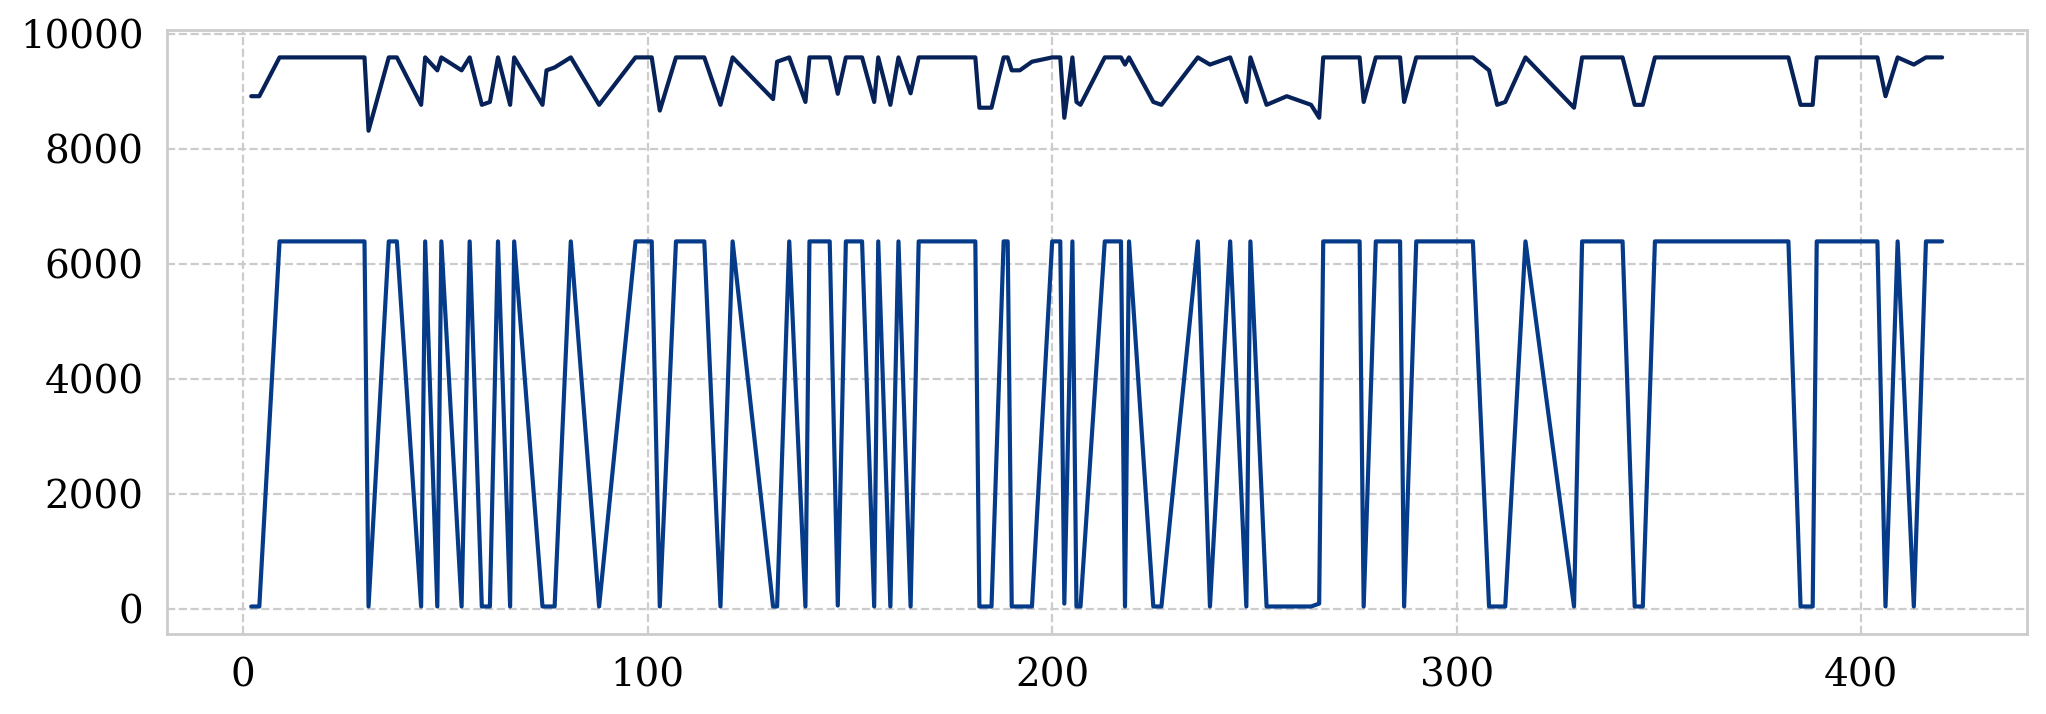

In [65]:
# Finding the average optimal now.
op_data_intervals
concated = pd.concat([op_data_intervals, fc_and_bw_data],axis=1)
print(f"Before filter shape: {concated.shape}")
filter_concated = filter_concated.loc[(filter_concated['AvgSpeed'] >= 1400)]
print(f"After filtering: {filter_concated.shape}")
mean_freq = filter_concated['Frequencies'].mean()
mean_bw = filter_concated['Bandwidths'].mean()
filter_concated['Frequencies'].plot()
filter_concated['Bandwidths'].plot()
len(filter_concated)


In [66]:
print(int(round(mean_freq)))
print(int(round(mean_bw))) # set this to 500?

9349
4002


## 2. Resampled signal

### Reading from file

In [ ]:
# The resampled signal is filtered (Lowcut at 200 Hz (highpass))
filtered_resampled_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/filtered_resampled/'

num_csvs = len([f for f in os.listdir(filtered_resampled_path) 
     if f.endswith('.csv') and os.path.isfile(os.path.join(filtered_resampled_path, f)) and f[0]=='f'])

filtered_resampled_signals = []
resample_freqs = []
columns = []
for i in range(num_csvs):
    acc=pd.read_csv(filtered_resampled_path+'filtered_resampled_'+str(i)+'.csv')
    columns.append('filtered_resampled_' + str(i))
    filtered_resampled_signals.append(acc.values)
    resample_freqs.append(acc.shape[0] / times[i][-1])

In [ ]:
resample_freqs
resample_freqs = pd.DataFrame(resample_freqs,columns)

## 3. Filtered, resampled signal with optimal bandpass based on SK

# Read kurtogram data

In [ ]:

fc_and_bw_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv';
frequencies_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/frequencies.csv';
file_names_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/file_name.txt';

fc_and_bw = pd.read_csv(fc_and_bw_path)
frequencies = pd.read_csv(frequencies_path)
file_names = pd.read_csv(file_names_path, header=None)

frequencies_numpy = np.asarray(frequencies).T
frequencies = pd.DataFrame(frequencies_numpy, columns= frequencies_numpy[0])
frequencies = frequencies.drop(frequencies.index[0]).reset_index(drop=True)

In [ ]:
kurt_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/kurtograms/';
kurt_file = f'{kurt_path}kgram_filtered_resampled_1.csv'
kurtogram = pd.read_csv(kurt_file, header=None)
plotting_methods.plot_kurtogram(kurtogram, frequencies['filtered_resampled_1.csv'])


In [ ]:
# Finding the optimal bandwidth by taking the mean from the SK
fc_and_bw_data = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv'
fc_and_bw_data = pd.read_csv(fc_and_bw_data)
# Make the file column to an int
fc_and_bw_data['File']=fc_and_bw_data['File'].apply(lambda x: int((str(x).split('_'))[2].split('.csv')[0]))
# Sort the df based on this
fc_and_bw_data=fc_and_bw_data.sort_values('File',ascending=True)
fc_and_bw_data = fc_and_bw_data.reset_index(drop=True)

In [ ]:
# How the frequencies and bandwidths vary across the intervals for wt4:
fc_and_bw_data['Frequencies'].plot()
fc_and_bw_data['Bandwidths'].plot()

In [ ]:
op_data_intervals
concated = pd.concat([op_data_intervals, fc_and_bw_data],axis=1)
print(f"Before filter shape: {concated.shape}")
filter_concated = concated.loc[(concated['AvgSpeed'] >= 1400)]
print(f"After filtering: {filter_concated.shape}")
mean_freq = filter_concated['Frequencies'].mean()
mean_bw = filter_concated['Bandwidths'].mean()
filter_concated['Frequencies'].plot()
filter_concated['Bandwidths'].plot()
filter_concated

In [ ]:
filter_concated = concated.loc[(concated['Frequencies'] > 18000)]
filter_concated

In [ ]:
# Remove higher peaks than 15000 Hz.
filter_concated = filter_concated.loc[(filter_concated['Frequencies'] <= 15000)]

In [ ]:
print(mean_freq)
print(mean_bw)
optimal_bandpass = {'highcut':mean_freq-mean_bw/2,'lowcut':mean_freq+mean_bw/2}

In [ ]:
print(f'Low: {round(int(optimal_bandpass["highcut"]))}, High: {int(round(optimal_bandpass["lowcut"]))}')

In [ ]:
resample_freqs=resample_freqs.rename(columns={0:'ResampleFreq'})

In [ ]:
len(filtered_resampled_csvs[1])

In [ ]:
signal = filtered_resampled_csvs[1]
len(signal)

In [ ]:
signal = filtered_resampled_csvs[1]
plt.plot(signal)

In [ ]:
signal = np.array(signal)
signal.shape

In [10]:
# Perform bandpass filtering

optimal_bandpass_signals = []
i=1

low = round(int(optimal_bandpass["highcut"]))
high = round(int(optimal_bandpass["lowcut"]))
fs_resample = resample_freqs['ResampleFreq'].iloc[i]
signal = filtered_resampled_csvs[i]
y = filters.butter_bandpass_filter(signal,low,high,fs_resample)
optimal_bandpass.append(y)

plt.plot(signal)
plt.margins(0)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()
plt.title('Resampled signal with highpass filtering')
plt.plot(y)
plt.xlabel("Samples")
plt.margins(0)
plt.ylabel("Amplitude")
plt.title(f'Interval {i} from WT04 filtered with average optimal bandpass from SK \n Component: Gearbox')
plt.title(f'Interval {i} from WT04 filtered with average optimal bandpass from SK \n Component: Gearbox')

NameError: name 'optimal_bandpass' is not defined

## Bandpass on raw signal with results from the spectral kurtosis

In [67]:
# Perform bandpass filtering on the raw signal!
def filter_based_on_optimal_bw(low,high,sig,time,plot=False):
    use_signal = sig
    signal = use_signal
    fs, _, _, _ =  envelope.get_sampling_freq(signal, time)

    #### Hardcoding the filters
    y = filters.butter_bandpass_filter(signal,low,high,fs)
    if plot:
        plt.plot(signal)
        plt.margins(0)
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()
        plt.title('Resampled signal with highpass filtering')
        plt.plot(y)
        plt.xlabel("Samples")
        plt.margins(0)
        plt.ylabel("Amplitude")
        plt.title(f'Interval {i} from WT04 filtered with average optimal bandpass from SK \n Component: Gearbox')
    return y

# Just loop through
optimal_bandpass_signals = []
for i in range(len(filtered_signals)):
    use_signal = filtered_signals[i][0:(len(filtered_signals[i])//2)]
    time = times[i][0:(len(filtered_signals[i])//2)]
    low = 8750
    high = 9250
    y = filter_based_on_optimal_bw(low,high,use_signal, time )
    optimal_bandpass_signals.append(y)

In [68]:
optimal_bandpass_signals

[array([[ 0.1486036 ],
        [ 0.33739452],
        [-0.56886007],
        ...,
        [-0.05973577],
        [ 0.05674253],
        [-0.0118274 ]]),
 array([[-0.98638265],
        [-1.27429489],
        [ 2.53804362],
        ...,
        [ 0.09930378],
        [ 0.01338065],
        [-0.09260289]]),
 array([[-0.4578837 ],
        [ 0.0672932 ],
        [ 0.49986004],
        ...,
        [ 0.08594754],
        [-0.07592709],
        [ 0.01219075]]),
 array([[ 0.3490015 ],
        [ 1.34899004],
        [-1.80534284],
        ...,
        [-0.28347457],
        [ 0.11396579],
        [ 0.10822784]]),
 array([[-0.16590776],
        [-2.28304191],
        [ 2.86250218],
        ...,
        [-0.17788116],
        [ 0.2123151 ],
        [-0.07915646]]),
 array([[ 0.07000668],
        [ 0.02245402],
        [-0.10847355],
        ...,
        [ 0.03121262],
        [-0.04574542],
        [ 0.02239351]]),
 array([[-0.05150152],
        [-1.13355552],
        [ 1.50212491],
        ...,


## 4. Demodulasation using EEMD signals

In [69]:
from PyEMD import EEMD
import numpy as np
import pylab as plt

In [ ]:
del filtered_signals
j = 0 # The index in the optimal bandpass array. Which interval is this actually?

#all_eIMFS = []

for j in range(len(optimal_bandpass_signals)):
    signal = (optimal_bandpass_signals[j]).reshape((len((optimal_bandpass_signals[j])), ))[0:20000]
    eIMFs=envelope_emd.eemd('WT04',filter_concated['File'].iloc[j],'gearbox',signal,time[0:20000],False)
    eIMFs = np.asarray(eIMFs)
    np.savetxt(f"/Volumes/OsvikExtra/signal_data/raw_filtered_2000Hz/gearbox/wt04/eemd_signals/interval_number_{filter_concated['File'].iloc[j]}.csv", eIMFs, delimiter=",")
    #all_eIMFS.append(eIMFs)

## 5. Selecting IMF: Correlation coefficient

In [43]:
e = np.array(eIMFs)
e.shape

(14, 20000)

In [44]:
corr_df = correlation_coeff.get_corr_coef(eIMFs)
corr_df

,Signal,Correlation coefficient
0,Raw signal,1.000000
1,IMF1,0.944640
2,IMF2,0.000859
3,IMF3,-0.000164
4,IMF4,0.000030
5,IMF5,-0.000067
6,IMF6,0.000105
7,IMF7,0.000119
8,IMF8,-0.000009
9,IMF9,-0.000057


## 6. Envelope spectral analysis

In [45]:
selected_IMF_index = 1

highut_lp = 2000
rectified = abs(eIMFs[selected_IMF_index])**2
bandpass_filtered_rect_lp = filters.butter_lp_filter(rectified, highut_lp, fs, order=5)

## 7. Frequency study (fault characteristics), fault development

Text(0, 0.5, 'Normalised amplitude')

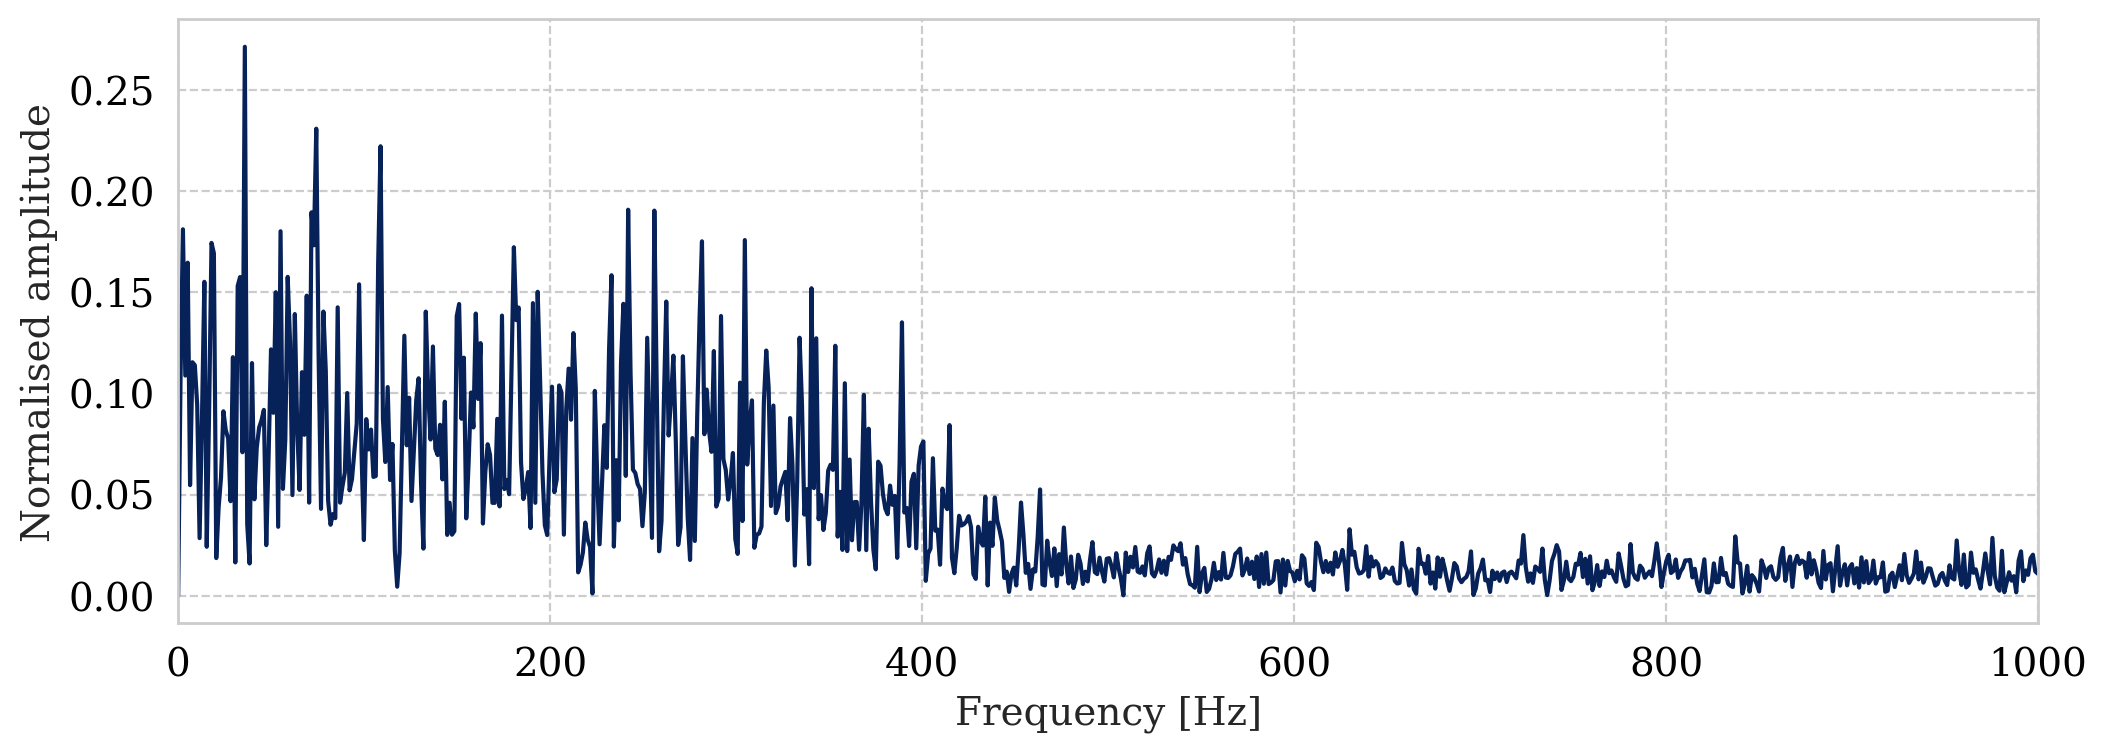

In [46]:
i = 0
final_signal = envelope.perform_fft(bandpass_filtered_rect_lp,time,plot=True)

plt.plot(final_signal['freq'],final_signal['fft_norm'])
plt.xlim(0,1000)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalised amplitude")

### Feature extraction from time domain

1. RMS
2. Kurtosis 
3. Skewness 
4. Peak to peak
5. Crest factor 
6. Shape factor 
7. Impulse factor 
8. Margin factor 
9. Mean 
10. STD 
11. Enery 
12. Energy entropy

In [57]:
# Feature extraction from time domain
rms, kurt, skewness, energy_mean, signal_mean = feature_extraction.get_time_domain_features(bandpass_filtered_rect_lp,fs)